**Импорт необходимых библиотек**

In [1]:
import numpy as np
import pandas as pd
import warnings
import matplotlib.pyplot as plt

from tqdm import tqdm
from urllib.parse import urlparse
from matplotlib.colors import LinearSegmentedColormap
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import(
    accuracy_score,
    f1_score,
    precision_score,
    recall_score,
    classification_report, 
    confusion_matrix,
)
from seaborn import (
    heatmap, 
    barplot, 
    countplot, 
    set_style,
    color_palette,
    set_palette,
    histplot
)

Для красоты

In [2]:
warnings.filterwarnings("ignore")

def get_gradient_palette(cmap, n_colors):
    return [cmap(i/n_colors) for i in range(n_colors)]

colors = ["#fd7e14", "#495057"]
gradient_cmap = LinearSegmentedColormap.from_list("orange_black_grad", colors, N=256)

set_style("whitegrid")
palette = color_palette("rocket");

**Загружаем данные**

In [3]:
train = pd.read_csv("Data/train.csv")

Посмотрим на наш датасет

In [4]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 64000 entries, 0 to 63999
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   url     64000 non-null  object
 1   result  64000 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 1000.1+ KB


In [5]:
train.describe()

,result
count,64000.000000
mean,0.374797
std,0.484074
min,0.000000
25%,0.000000
50%,0.000000
75%,1.000000
max,1.000000


In [6]:
train.head()

,url,result
0,https://caseforpages1885777.web.app/,1
1,https://www.tu-auto.com/,0
2,http://www.bancm.co/desbloqueos/USERscis=login...,1
3,https://doccomo.ne.uqag.xyz,1
4,http://academics.smcvt.edu/sburks/Definition_s...,0


In [7]:
train.shape

(64000, 2)

In [8]:
train = train.drop_duplicates()

In [9]:
train.shape

(63902, 2)

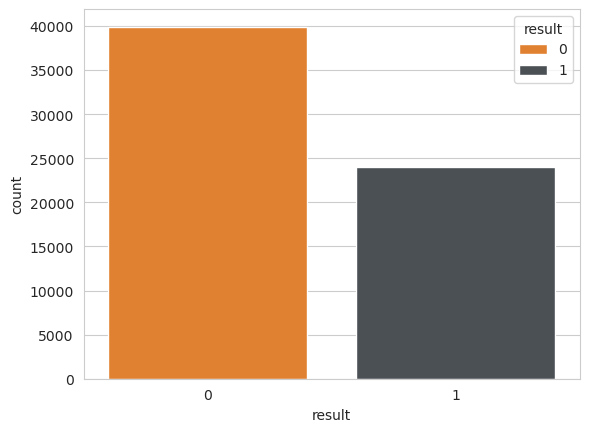

In [10]:
countplot(data=pd.DataFrame(train), x="result", palette=colors, hue="result");

Как видно на графике, присутствует дисбаланс в данных

**Переходим к обучению модели**

In [11]:
X = train["url"]
y = train["result"]

Извлечем фичи из ссылок

In [12]:
# def parse_url_features(urls):
#     results = []
#     for url in tqdm(urls):
#         parsed_url = urlparse(url)
#         features = {}
        
#         features['length'] = len(url)
#         features['num_subdomains'] = url.count('.')
#         features['num_dots'] = url.count('.')
#         features['is_https'] = 1 if parsed_url.scheme == 'https' else 0
#         features['path_length'] = len(parsed_url.path)
#         features['special_chars'] = 1 if any(char in url for char in ['#', '%', '&']) else 0
#         results.append(features)
    
#     return pd.DataFrame(results)

# features_dataframe = parse_url_features(X.to_list())

In [13]:
from nltk.tokenize import RegexpTokenizer

In [14]:
tokenizer = RegexpTokenizer(r'[\w\d]+')

In [15]:
tokenizer.tokenize(X[0])

['https', 'caseforpages1885777', 'web', 'app']

In [16]:
from sklearn.feature_extraction.text import TfidfVectorizer

In [31]:
vectorizer = TfidfVectorizer(max_features=1024)

In [32]:
X_vec = vectorizer.fit_transform(X.apply(lambda x: ' '.join(tokenizer.tokenize(x))))

In [33]:
from xgboost import XGBClassifier

In [34]:

from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score, make_scorer

In [35]:
random_state = 42

In [22]:
# Создание словаря с диапазонами значений для бустинга
param_grid_boosting = {
    'n_estimators': [50, 100, 150, 200], 
    'max_depth': range(3, 11), 
    'random_state': [random_state],
    'learning_rate': [0.01, 0.1, 0.2]
}

In [36]:
X_train, X_test, y_train, y_test = train_test_split(
    X_vec, 
    y, 
    random_state=42, 
    test_size=0.2, 
    shuffle=True
)

In [24]:
# Исчерпывающий поиск гиперпараметров по сетке (Grid Search) для XGBClassifier по заданным диапазонам значений 
gs = GridSearchCV(XGBClassifier(), param_grid=param_grid_boosting, scoring=make_scorer(accuracy_score), cv=3)
gs.fit(X_train, y_train)

GridSearchCV(cv=3,
             estimator=XGBClassifier(base_score=None, booster=None,
                                     callbacks=None, colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None, device=None,
                                     early_stopping_rounds=None,
                                     enable_categorical=False, eval_metric=None,
                                     feature_types=None, feature_weights=None,
                                     gamma=None, grow_policy=None,
                                     importance_type=None,
                                     interaction_constraints=Non...
                                     max_delta_step=None, max_depth=None,
                                     max_leaves=None, min_child_weight=None,
                                     missing=nan, monotone_constraints=None,
                                     multi_strategy=None, n_estimators=None,
                                     n_jobs=None, num_parallel_tree=None, ...),
             param_grid={'learning_rate': [0.01, 0.1, 0.2],
                         'max_depth': range(3, 11),
                         'n_estimators': [50, 100, 150, 200],
                         'random_state': [42]},
             scoring=make_scorer(accuracy_score, response_method='predict'))

In [26]:
# Обучение CatBoostClassifier с лучшими гиперпараметрами на всей обучающей выборке и подсчет метрики на тестовой выборке
model = XGBClassifier(**gs.best_params_)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

# print(f'CatBoostClassifier: {(y_test, y_pred, average='macro')}')

In [27]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.88      0.92      0.90      8015
           1       0.85      0.79      0.82      4766

    accuracy                           0.87     12781
   macro avg       0.87      0.86      0.86     12781
weighted avg       0.87      0.87      0.87     12781



In [28]:
# Вывод лучших гиперпараметров
gs.best_params_()

TypeError: 'dict' object is not callable

In [37]:
X_train

<51121x1024 sparse matrix of type '<class 'numpy.float64'>'
	with 267243 stored elements in Compressed Sparse Row format>

In [38]:
# Обучение CatBoostClassifier с лучшими гиперпараметрами на всей обучающей выборке и подсчет метрики на тестовой выборке
model = XGBClassifier()
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

# print(f'CatBoostClassifier: {(y_test, y_pred, average='macro')}')

In [39]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.91      0.94      0.93      8015
           1       0.90      0.84      0.87      4766

    accuracy                           0.91     12781
   macro avg       0.91      0.89      0.90     12781
weighted avg       0.91      0.91      0.91     12781

